Assign 8: Transfer Learning with a CNN
======================================

This notebook has been adapted from the [PyTorch tutorial on transfer learning](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).
Similar to the original tutorial, this one will demonstrate two different variations of transfer learning.

As discussed in class, __[transfer learning](https://en.wikipedia.org/wiki/Transfer_learning)__ in machine learning is about utilizing an already-trained model for your specific problem or use case.

Large neural networks can take a significant amount of resources to train, in terms of long training time,
massive dataset size, and costly computer hardware. Given that, it's
no surprise that we would want to avoid training a model from scratch. This is where transfer learning comes in.

Transfer learning starts by taking a pre-trained neural network model that was trained to, say, predict which of
1000 possible types of animals is in an image. This model is then used/repurposed/recycled to, say, predict which of two animals
is in an image. Note that two types of animals that you want to perform classification on don't even need to be part of the original 1000 animals.

There are two types of transfer learning techniques we'll try, these are:

-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.
-   **ConvNet as fixed feature extractor**: Here, we will freeze the
    weights for all of the network except that of the final fully
    connected layer. This last fully connected layer is replaced with a
    new one with random weights and only this layer is trained.

We will also compare those two approaches to the naive approach of trying to train a similar CNN from scratch.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/CS3120/blob/main/lab4_transfer_learning.ipynb)

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/sgeinitz/CS3120/blob/main/lab4_transfer_learning.ipynb)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory


# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
!git clone https://github.com/sgeinitz/CS3120.git

Cloning into 'CS3120'...
remote: Enumerating objects: 448, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 448 (delta 12), reused 38 (delta 12), pack-reused 409 (from 1)
Receiving objects: 100% (448/448), 45.44 MiB | 11.90 MiB/s, done.
Resolving deltas: 100% (13/13), done.


Load Data
=========

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we\'re going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants
and bees. There are 75 validation images for each class. 

Trying to train a deep learning model from scratch with just one or two hundred images is not really possible. 
But, we're not going to train the deep learning model from scratch. Instead, we're going to use one that was already trained on millions 
of images to classify which of one-thousand (1000) possible categories the contents of the image falls into. 
We'll then going to fine tune the model for our specific problem of binary classification, namely: Bee or Ant (i.e, not Bee)).

Since we are using transfer learning, and *not* training the model from scratch, one or two hundred images is plenty.


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'CS3120/lab4_transfer_learning_images/hymenoptera'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# check for a GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
# check for an Apple MPS device
elif torch.backends.mps.is_available():
    device = torch.device("mps")
# otherwise use the CPU
else:
    device = torch.device("cpu")

# print out which device is being used
print(f"Using device: {device}")

Examine a few Images
======================

Let\'s visualize a few training images so as to understand the data
augmentations.

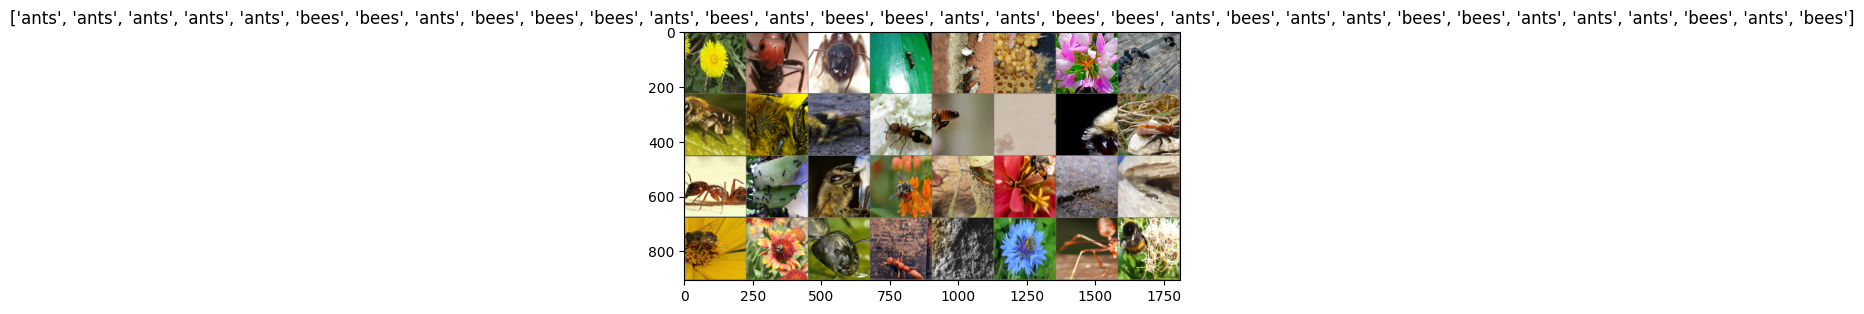

In [31]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
==================

Now, let\'s write a general function to train a model. 

Notice that in addition to using mini-batches, there is another so-called _trick_ we're using. Namely, the use 
of a __scheduler__ to modify the learning rate over time. 

In the following, parameter `scheduler` is a LR scheduler object from
`torch.optim.lr_scheduler`. Right now it is only a a parameter in the `train_model` function, but you will see 
it declared/instantiated later on in this notebook. 


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    b_losses = {'train':[], 'val':[]}
    e_losses = {'train':[], 'val':[]}

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    b_losses[phase].append(loss.item())

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.float() / dataset_sizes[phase]

                # print loss and accuraacy every 4 epochs
                if epoch % 4 == 0:
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                # save loss for plotting later on
                e_losses[phase].append(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, e_losses, b_losses

Visualizing the model predictions
=================================

Generic function to display predictions for a few images


In [48]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Model A: Finetuning the ConvNet
======================

Load a pretrained model and reset final fully connected layer.

This is also where we create instances of the `optimizer` and `scheduler` objects, both of which are then passed into 
the `train_model` function as parameters. 

In [ ]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# In general, this could be written as ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
==================

This will take 1-2 minutes on a GPU, or around 20-25 minutes with a CPU. 


In [50]:
model_ft, epoch_losses, batch_losses = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7179 Acc: 0.5697
val Loss: 0.7110 Acc: 0.5490

Epoch 1/24
----------
train Loss: 0.5592 Acc: 0.6762
val Loss: 0.3239 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.2807 Acc: 0.9016
val Loss: 0.2479 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.3205 Acc: 0.8770
val Loss: 0.2214 Acc: 0.9346

Epoch 4/24
----------
train Loss: 0.1766 Acc: 0.9385
val Loss: 0.1808 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.1834 Acc: 0.9426
val Loss: 0.1681 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.1634 Acc: 0.9467
val Loss: 0.1672 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.1325 Acc: 0.9508
val Loss: 0.1672 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.1266 Acc: 0.9795
val Loss: 0.1672 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.1255 Acc: 0.9672
val Loss: 0.1676 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.1549 Acc: 0.9549
val Loss: 0.1683 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.1312 Acc: 0.9590
val Loss: 0.1664 Acc: 0.9412

Ep

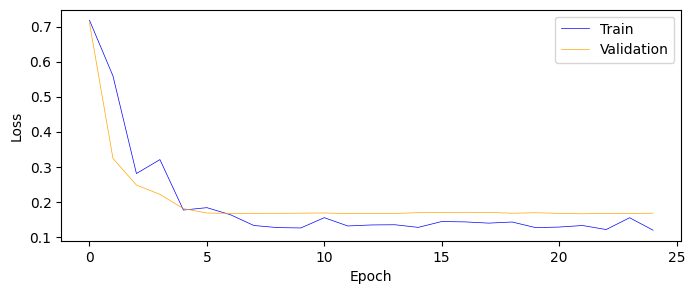

In [53]:
# plot the loss curves
plt.figure(figsize=(8, 3))
plt.plot(range(len(epoch_losses['train'])), epoch_losses['train'], c='blue', linewidth=0.5)
plt.plot(range(len(epoch_losses['val'])), epoch_losses['val'], c='orange', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(('Train','Validation'))

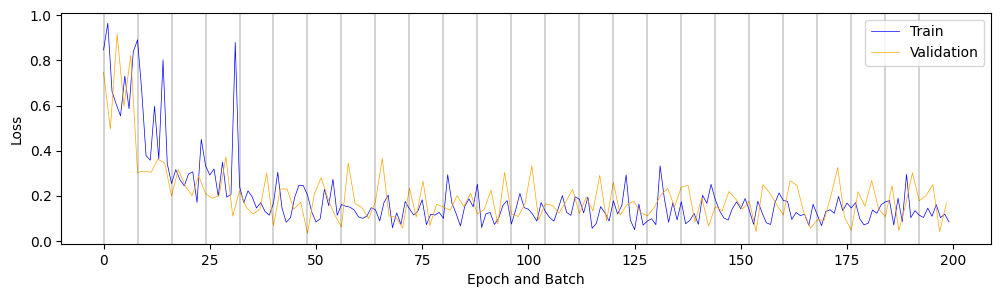

In [ ]:
# plot the loss curves for each (mini) batch
plt.figure(figsize=(12, 3))
val_ticks = [(i)*len(batch_losses['train'])/len(batch_losses['val']) for i in range(len(batch_losses['val']))]
plt.plot(range(len(batch_losses['train'])), batch_losses['train'], c='blue', linewidth=0.5)
plt.plot(val_ticks, batch_losses['val'], c='orange', linewidth=0.5)
for i in range(25):
    plt.axvline(x=i*len(batch_losses['train'])/25, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Epoch and Batch')
plt.legend(('Train','Validation'))

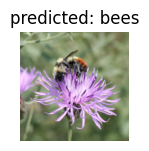

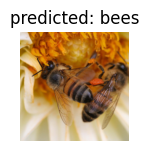

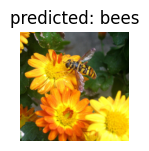

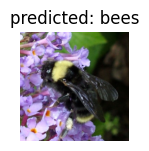

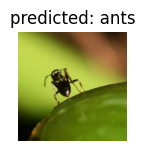

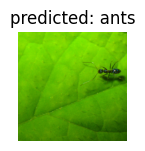

In [58]:
visualize_model(model_ft)

Model B: ConvNet as fixed feature extractor
==================================

Here, we need to freeze all the network except the final layer. We need
to set `requires_grad = False` to freeze the parameters so that the
gradients are not computed in `backward()`.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).


In [59]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
==================

Now use `train_model` again, but with the above model object, which has frozen all the parameters except for those in the final layer. 

***
### Q1: Will this run faster or slower than the earlier training run? Explain why or why not?

\<INPUT YOUR ANSWER TO Q1 HERE\>
***

In [60]:
model_conv, epoch_losses, batch_losses = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8046 Acc: 0.4508
val Loss: 0.8155 Acc: 0.4771

Epoch 1/24
----------
train Loss: 0.6158 Acc: 0.6639
val Loss: 0.4643 Acc: 0.8366

Epoch 2/24
----------
train Loss: 0.4462 Acc: 0.8156
val Loss: 0.3463 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.3388 Acc: 0.8689
val Loss: 0.2769 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.3158 Acc: 0.8893
val Loss: 0.2455 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.2537 Acc: 0.9098
val Loss: 0.2277 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.2348 Acc: 0.9180
val Loss: 0.2202 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.2073 Acc: 0.9467
val Loss: 0.2168 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2541 Acc: 0.9139
val Loss: 0.2179 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.2244 Acc: 0.9344
val Loss: 0.2123 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.2611 Acc: 0.9016
val Loss: 0.2168 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.2377 Acc: 0.9221
val Loss: 0.2125 Acc: 0.9542

Ep

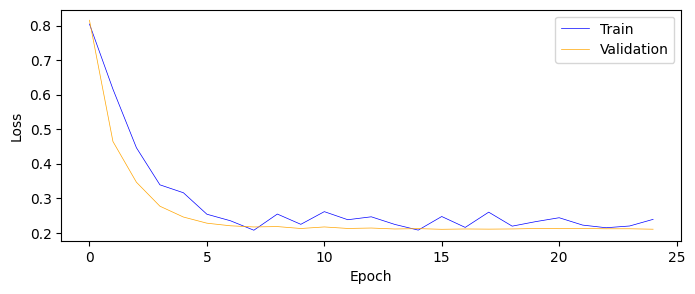

In [61]:
# plot the loss curves
plt.figure(figsize=(8, 3))
plt.plot(range(len(epoch_losses['train'])), epoch_losses['train'], c='blue', linewidth=0.5)
plt.plot(range(len(epoch_losses['val'])), epoch_losses['val'], c='orange', linewidth=0.5)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(('Train','Validation'))

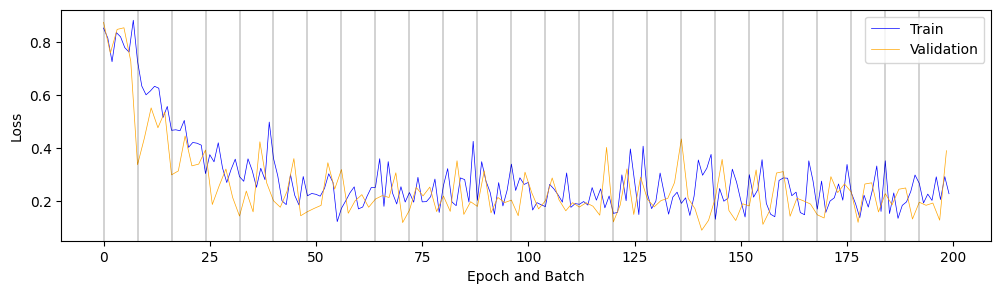

In [ ]:
# plot the loss curves for each (mini) batch
plt.figure(figsize=(12, 3))
val_ticks = [(i)*len(batch_losses['train'])/len(batch_losses['val']) for i in range(len(batch_losses['val']))]
plt.plot(range(len(batch_losses['train'])), batch_losses['train'], c='blue', linewidth=0.5)
plt.plot(val_ticks, batch_losses['val'], c='orange', linewidth=0.5)
for i in range(25):
    plt.axvline(x=i*len(batch_losses['train'])/25, c='black', lw=0.25)
plt.ylabel('Loss')
plt.xlabel('Batch')
plt.legend(('Train','Validation'))

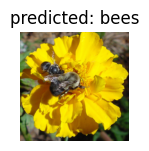

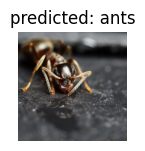

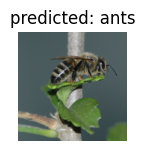

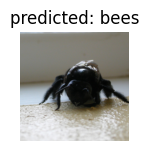

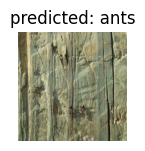

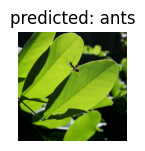

In [63]:
visualize_model(model_conv)

plt.ioff()
plt.show()

***
### Q2: Which of the two models worked best (in terms of validation accuracy)? Model A or Model B? Explain why you think this might be?

\<INPUT YOUR ANSWER TO Q2 HERE\>
***

***
### Q3: Change the batch size from 16 to 32 and then re-run both model training runs. How does this change the training and performance?

\<INPUT YOUR ANSWER TO Q3 HERE\>
***




***
### Q4: Change the batch size from 32 to 4 and then re-run both model training runs. How does this change the training and performance? 
Also comment on whether there are now more or less mini-batches. 

\<INPUT YOUR ANSWER TO Q3 HERE\>
***

Inference on one Images
==========================

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.


In [64]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

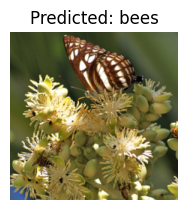

In [65]:
visualize_model_predictions(
    model_conv,
    img_path='CS3120/lab4_transfer_learning_images/hymenoptera/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()